In [1]:
import cv2
import numpy as np
import struct
import time
import matplotlib.pyplot as plt
import os
import re
import sys
from pathlib import Path

from read_cine import read_cine, convert_cine_to_avi
from track_object import track_object, detect_chamber, update_tracking_result, show_tracking_results

In [27]:
cine_path = r"E:\good_data\He3kA_B250G500G_pl0t20_uw17t47_P24\Y20241101_P24_z13_x40_y0@350_008.cine"
avi_path = cine_path.replace('.cine', '.avi')

tarr, frarr, dt = read_cine(cine_path)

# convert_cine_to_avi(frarr, avi_path)

Reading .cine file...
starting frame number: 0
total frames: 1001
frame rate: 20000
Done reading .cine file (3.3 s)


In [3]:
parr, frarr, cf = track_object(avi_path)

Processing 1001 frames
Hough failed, using contour fallback
Chamber detected at (1064, 981) with radius 616px
Frame closest to chamber center: 508


Hough failed, using contour fallback
Chamber detected at (1126, 1112) with radius 612px
0.01775


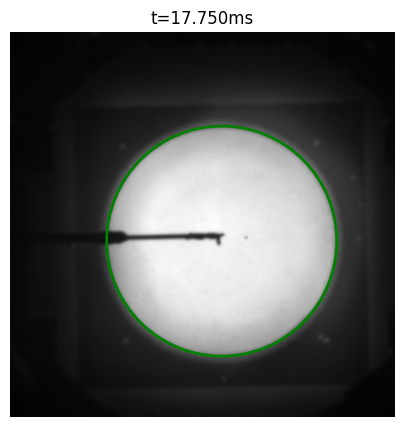

In [32]:
frame_num = 355

cap = cv2.VideoCapture(avi_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
ret, frame = cap.read()
if not ret:
    raise ValueError(f"Could not read frame")

# Detect chamber
(cx, cy), chamber_radius = detect_chamber(frame)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Display the original frame
plt.figure(figsize=(15, 5))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Draw the chamber as a circle
chamber_circle = plt.Circle((cx, cy), chamber_radius, fill=False, color='green', linewidth=2)
plt.gca().add_patch(chamber_circle)

plt.title(f"t={tarr[frame_num] * 1e3:.3f}ms")
plt.axis('off')

cap.release()

print(tarr[frame_num])

In [ ]:
v = 9.8*np.sqrt(2*1/9.8) # velocity at center of chamber in m/s

t1 = 0.027 - tarr[cf]
t2 = 0.037 - tarr[cf]
print(t1)
print(t2)

x1 = v*t1 + 0.5*9.8*t1**2
x2 = v*t2 + 0.5*9.8*t2**2

print(x1)
print(x2)

In [8]:
tr_ifn = r"E:\good_data\He3kA_B250G500G_pl0t20_uw17t47_P24\tracking_results.npy"
show_tracking_results(tr_ifn)

Found 19 entries in tracking results

File: Y20241101_P24_z13_x40_y0@420_011.cine
  Frame: 450
  Time: 0.022500s

File: Y20241101_P24_z13_x40_y0@300_012.cine
  Frame: 315
  Time: 0.015750s

File: Y20241101_P24_z13_x40_y0@70_013.cine
  Frame: 605
  Time: 0.005250s

File: Y20241101_P24_z13_x40_y0@250_014.cine
  Frame: 770
  Time: 0.013500s

File: Y20241101_P24_z13_x40_y0@200_015.cine
  Frame: 425
  Time: 0.011250s

File: Y20241101_P24_z13_x40_y0@300_016.cine
  Frame: 523
  Time: 0.016150s

File: Y20241101_P24_z13_x40_y0@40_017.cine
  Frame: 216
  Time: -0.014200s

File: Y20241101_P24_z13_x40_y0@0_018.cine
  Frame: 524
  Time: 0.001200s

File: Y20241101_P24_z13_x40_y0@-60_019.cine
  Frame: 467
  Time: -0.001650s

File: Y20241101_P24_z13_x40_y0@100_020.cine
  Frame: 640
  Time: 0.007000s

File: Y20241101_P24_z13_x40_y0@350_008.cine
  Frame: 907
  Time: 0.045350s

File: Y20241101_P24_z13_x40_y0@70_009.cine
  Frame: 598
  Time: 0.004900s

File: Y20241101_P24_z13_x40_y0@250_010.cine
  Frame: 

In [33]:
update_tracking_result(tr_ifn, cine_path, cf_new=frame_num, ct_new=tarr[frame_num])

Loaded existing tracking results with 19 entries

Current values for Y20241101_P24_z13_x40_y0@350_008.cine:
  Frame: 907
  Time: 0.045350s

Updated values:
  Frame: 355
  Time: 0.017750s
